In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from predictor import Predictor

# Запись данных

Здесь в примере данные записывюатся из json-файла, но код можно переписать и подавать сообщения из Kafka

In [2]:
model = Predictor()
# load data to model
import json

with open('data.json', 'r') as f:
    data = json.load(f)

i = 0

for timestamp in data:

    if i % 12 == 0:
        model.write_mes(timestamp)
        
    i = (i + 1) % 12

Пример сообщения

In [3]:
#print(data[0])

# Часть 1. Линейный тренд
Просто апроксимация по МНК прямой линей

## Подбор параметров
После того как загружено достаточное число данных можно запустить метод, чтобы подобрать коэфиценты тренда или любой другой имплеменитрвоанной модели

In [4]:
model.fit_linear(n_days=30)

## Предсказание
После того как были заданы предупредительные значения для вибраций, можно запустить метод для предсказания даты выхода из строя. 

Важно!
 - В качестве даты выхода для каждого подшипника будет передана наискорейшая дата по всем вибрациям (горизонт, верт и аксиальные)
 - Дата прогнозируется только для тех подшипников, для которых есть амлитуда вибраций в Kafka

 Выходные данные:

 Словарь, ключ - индекс подшипника, 
 значение - (delta-время в днях с 2022.01.01 00:00 , ошибка по времени в днях, причина отказа (ключ для вибраций))

In [5]:
model.predict_linear()

{0: (847.7770838071476, 51.07030255560413, 'Vibration_horizntal'),
 1: (689.1179387609247, 29.209499576094384, 'Vibration_horizntal'),
 6: (446.2008020456948, 19.481445755438543, 'Vibration_vertical'),
 7: (460.61286739961344, 14.636999488643408, 'Vibration_horizntal')}

## Визуализация данных
это уже просто как пример что можно и обращаться к функции тренда в модели явно для потсроения графиков

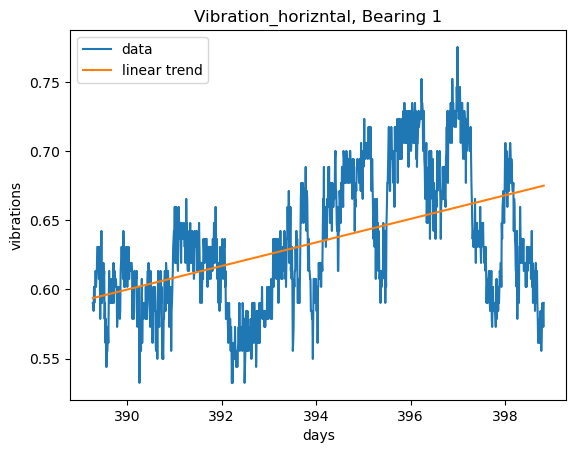

In [16]:
key = 'Vibration_horizntal'

plt.title('{}, Bearing 1'.format(key))

x = model.data_value[0][key]

plt.plot(model.t, x, label='data')

t_pred = np.array([model.t[0], model.t[-1]])

plt.plot(t_pred, model.trend_linear(t_pred, key, 0), label='linear trend')
plt.legend()
plt.xlabel('days')
plt.ylabel('vibrations')
plt.show()

## Анализ автокореляции
Просто для себя анализ того насколько точки скореллированы между собой

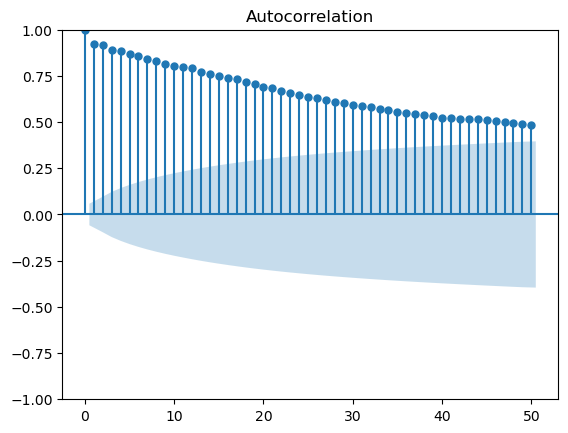

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(x, lags=50)
plt.show()

# Предсказание по Модели Холта-Уинтерса
Тут уже чуть более продвинутое предсказание по модели, что учитывает сезонность и белый шум

## Подбор параметров
После того как загружено достаточное число данных можно запустить метод, чтобы подобрать коэфиценты тренда или любой другой имплеменитрвоанной модели

In [8]:
model.fit_halt_winters(n_days=30)

/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


## Предсказание
После того как были заданы предупредительные значения для вибраций, можно запустить метод для предсказания даты выхода из строя. 

Важно!
 - В качестве даты выхода для каждого подшипника будет передана наискорейшая дата по всем вибрациям (горизонт, верт и аксиальные)
 - Дата прогнозируется только для тех подшипников, для которых есть амлитуда вибраций в Kafka

 Выходные данные:

 Словарь, ключ - индекс подшипника, 
 значение - (delta-время в днях с 2022.01.01 00:00 , ошибка по времени в днях, причина отказа (ключ для вибраций))

In [9]:
model.predict_hw()

{0: (5116.263599824352, 0.02171999950908201, 'Vibration_vertical'),
 1: (978.483721825266, 0.028668440890954286, 'Vibration_horizntal'),
 6: (538.0213608980051, 0.030286658979167387, 'Vibration_horizntal'),
 7: (413.1195546594662, 0.42228493607907525, 'Vibration_axis')}

## Визуализация данных
это уже просто как пример что можно и обращаться к функции тренда в модели явно для потсроения графиков

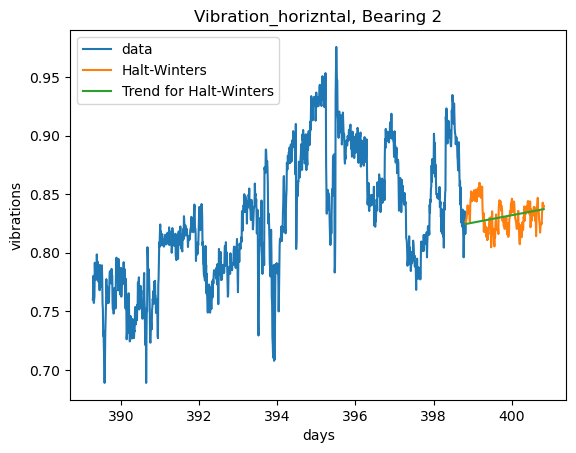

In [15]:
key = 'Vibration_horizntal'

plt.title('{}, Bearing 2'.format(key))

x = model.data_value[1][key]

plt.plot(model.t, x, label='data')

t_pred, x_pred = model.build_hw(1, key, 2)

plt.plot(t_pred, x_pred, label='Halt-Winters')

t_pred_tr = np.array([model.t[-1], model.t[-1]+2])
x_pred_tr = model.trend_hw(t_pred_tr, key, 1)

plt.plot(t_pred_tr, x_pred_tr, label='Trend for Halt-Winters')
plt.legend()
plt.xlabel('days')
plt.ylabel('vibrations')
plt.show()